In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from IPython import display
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
fashionMNIST=tf.keras.datasets.fashion_mnist
(trainImages,trainLabels),(testImages,testLabels)=fashionMNIST.load_data()

trainImages=trainImages.reshape(trainImages.shape[0],28,28,1).astype('float32')
trainImages=(trainImages-127.5)/127.5
trainLabels=tf.one_hot(trainLabels,depth=10)
trainLabels=tf.cast(trainLabels,tf.float32)

bufferSize=len(trainImages)
batchSize=256
trainDataset=tf.data.Dataset.from_tensor_slices((trainImages,trainLabels)).shuffle(bufferSize).batch(batchSize)

In [3]:
generator=tf.keras.Sequential()
generator.add(layers.Dense(7*7*256,use_bias=False,input_shape=(110,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7,7,256)))
assert generator.output_shape==(None,7,7,256)

generator.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
assert generator.output_shape==(None,7,7,128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
assert generator.output_shape==(None,14,14,64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
assert generator.output_shape==(None,28,28,1)

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1379840   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [4]:
discriminator=tf.keras.Sequential()
discriminator.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,11]))

discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        17664     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [5]:
generatorOptimizer=tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer=tf.keras.optimizers.Adam(1e-4)

In [6]:
def calculate_discriminator_loss(realOutput,fakeOutput):
    crossEntropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    realLoss=crossEntropy(tf.ones_like(realOutput),realOutput)
    fakeLoss=crossEntropy(tf.zeros_like(fakeOutput),fakeOutput)
    totalLoss=realLoss+fakeLoss
    return totalLoss

def calculate_generator_loss(fakeOutput):
    crossEntropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    totalLoss=crossEntropy(tf.ones_like(fakeOutput),fakeOutput)
    return totalLoss

In [7]:
@tf.function
def train_single_batch(datasetBatch):
    trainImages=datasetBatch[0]
    trainLabels=datasetBatch[1]
    with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
        randomNoise=tf.random.normal([trainImages.get_shape()[0],noiseDimansion])
        randomNoiseInput=tf.concat([randomNoise,trainLabels],1)
        generatedImage=generator(randomNoiseInput,training=True)

        labelInput=tf.reshape(trainLabels,[trainImages.get_shape()[0],1,1,10])
        imageInput=tf.concat([trainImages,labelInput*tf.ones([trainImages.get_shape()[0],28,28,10])],3)
        generatedInput=tf.concat([generatedImage,labelInput*tf.ones([trainImages.get_shape()[0],28,28,10])],3)

        realOutput=discriminator(imageInput,training=True)
        fakeOutput=discriminator(generatedInput,training=True)

        generaterLoss=calculate_generator_loss(fakeOutput)
        discriminatorLoss=calculate_discriminator_loss(realOutput,fakeOutput)

    generatorGradients=generatorTape.gradient(generaterLoss,generator.trainable_variables)
    discriminatorGradients=discriminatorTape.gradient(discriminatorLoss,discriminator.trainable_variables)

    generatorOptimizer.apply_gradients(zip(generatorGradients,generator.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(discriminatorGradients,discriminator.trainable_variables))

In [8]:
def generate_image(generator,randomSeed):
    predictions=generator(randomSeed,training=False)
    plt.figure(figsize=(10,10))
    for i in range(predictions.shape[0]):
        plt.subplot(10,10,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
    plt.show()

In [9]:
modelCkptDir='./model_ckpt/fashion_MNIST/'
isModelCkptExist=False
os.makedirs(modelCkptDir) if not os.path.exists(modelCkptDir) else None
isModelCkptExist=True if not len(os.listdir(modelCkptDir))==0 else None

modelCkpt=tf.train.Checkpoint(generator_optimizer=generatorOptimizer,
                              discriminator_optimizer=discriminatorOptimizer,
                              generator=generator,
                              discriminator=discriminator)

In [10]:
noiseDimansion=100
generateNumber=100

randomSeed=tf.random.normal([generateNumber,noiseDimansion])
imageTags=[i%10 for i in range(generateNumber)]
imageTags=tf.one_hot(imageTags,depth=10)
imageTags=tf.cast(imageTags,tf.float32)
randomSeed=tf.concat([randomSeed,imageTags],1)

model ckpt found, all parameter has been restored


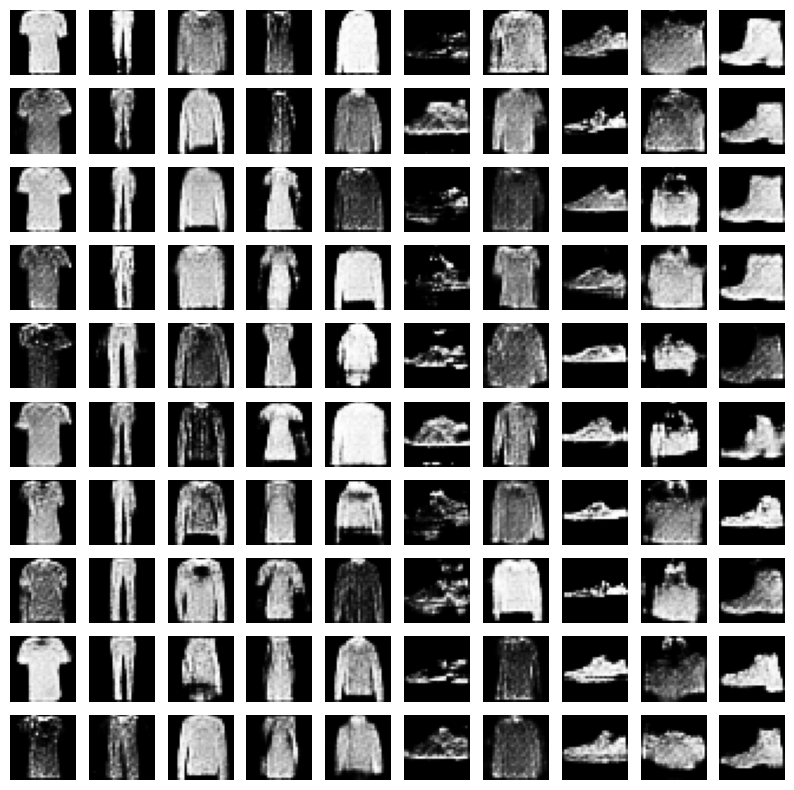

In [12]:
epochs=100
if isModelCkptExist==False:
    print('model ckpt not found, training and storing it now')
    for epoch in range(epochs):
        for datasetBatch in trainDataset:
            train_single_batch(datasetBatch)

        display.clear_output(wait=True)
        generate_image(generator,randomSeed)
        if (epoch+1)%20==0:
            modelCkpt.save(file_prefix=modelCkptDir)
else:
    print('model ckpt found, all parameter has been restored')
    modelCkpt.restore(tf.train.latest_checkpoint(modelCkptDir))
    generate_image(generator,randomSeed)